# Dog Breed Classification

##### By Christine Dossa and Irene Luwabelwa

### Project Overview

The goal of this project is to classify dog breeds using traditional machine learning techniques such as Support Vector Machines (SVM) and Random Forests. The dataset used is the Stanford Dogs Dataset, which contains 20,580 images of 120 different dog breeds from around the world. The dataset is sourced from Kaggle

### Data and the Purpose of the Project

The Stanford Dogs Dataset is a large collection of dog pictures, each labeled with it's corresponding breed. The purpose of this project is to explore various machine learning techniques to classify these images into their respective breeds. The project is divided into several steps, including data preprocessing, feature extraction, model training, and evaluation.

Dataset: Stanford Dogs Dataset
Source: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset

In [58]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import skew
from skimage import io, transform, exposure, feature, filters, color, measure
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn import discriminant_analysis
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import seaborn as sn
import random

## Data Preprocessing

The first step was data preprocessing. Here we loaded the dataset, normalized the images, and extracted the relevant features for classification.

In [59]:
# Load dataset and preprocess images

# Define the path to the annotation and image directories
# annotation_path = 'C:/Users/ruthd/OneDrive - Lake Forest College/csci250/CS450/annotations/Annotation'
# image_path = 'C:/Users/ruthd/OneDrive - Lake Forest College/csci250/CS450/images/Images'

annotation_path = 'standford-dogs-dataset/annotations/Annotation'
image_path = 'standford-dogs-dataset/images/Images'

breed_list = os.listdir(annotation_path)
newlist = []
for item in breed_list:
    try:
        os.listdir(annotation_path + '/' + item)
        newlist.append(item)
    except:
        continue
breed_list = newlist
breed_list[0:5]

['n02097658-silky_terrier',
 'n02092002-Scottish_deerhound',
 'n02099849-Chesapeake_Bay_retriever',
 'n02091244-Ibizan_hound',
 'n02095314-wire-haired_fox_terrier']

In [60]:
# Function to normalize pixel values
def imNormalize(image):
    if len(image.shape) == 2:
        r = image
        g = image
        b = image
    else:
        r = image[:,:,0]
        g = image[:,:,1]
        b = image[:,:,2]
    
    r = r - r.min()
    r = r / r.max()
    r = np.uint8(r * 255)
    
    g = g - g.min()
    g = g / g.max()
    g = np.uint8(g * 255)
    
    b = b - b.min()
    b = b / b.max()
    b = np.uint8(b * 255)
    
    return np.stack((r,g,b), axis=2)

# Function to compute color histogram
def colorHistogram(image):
    image = color.rgb2hsv(image)
    
    h1 = exposure.histogram(image[:,:,0])
    h2 = exposure.histogram(image[:,:,1])
    h3 = exposure.histogram(image[:,:,2])
    h = np.concatenate((h1[0], h2[0], h3[0]), axis=None)
    h = h / (image.shape[0] * image.shape[1])
    return np.array(h)

# Function to compute Local Binary Patterns (LBP)
def lbp_features(image):
    if len(image.shape) > 2:
        gray = color.rgb2gray(image)
    else:
        gray = image
    gray_uint8 = np.uint8(gray * 255)
    lbp = feature.local_binary_pattern(gray_uint8, P=8, R=1, method='uniform')
    n_bins = 10  # Fewer bins for efficiency
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    return np.array(lbp_hist)

# Function to compute gabor Moments
def gabor_features(image, num_scales=2, num_orientations=4):
    if len(image.shape) > 2:
        gray = color.rgb2gray(image)
    else:
        gray = image
    gray = np.float32(gray)
    features = []

    # Apply Gabor filters at different scales and orientations
    for scale in range(num_scales):
        for orientation in range(num_orientations):
            frequency = 0.1 * (scale + 1)  # Adjusted for speed
            theta = np.pi * orientation / num_orientations

            # Apply Gabor filter
            filtered_img, _ = filters.gabor(gray, frequency=frequency, theta=theta, sigma_x=1.5, sigma_y=1.5)

            # Extract statistical features
            features.append(np.mean(filtered_img))
            features.append(np.std(filtered_img))
            features.append(skew(filtered_img.ravel()))

    return np.array(features)

    return np.array(features)

def haralick_features(image):
    # Convert to grayscale
    if len(image.shape) > 2:
        gray = color.rgb2gray(image)
    else:
        gray = image
    
    gray_uint8 = (gray * 255).astype(np.uint8)
    
    # Compute GLCM with 4 directions
    glcm = feature.graycomatrix(gray_uint8, 
                       distances=[1], 
                       angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                       symmetric=True, 
                       normed=True)
    
    # Extract 6 standard features (average across directions)
    features = []
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        features.append(feature.graycoprops(glcm, prop).mean())
    
    return np.array(features)

# Function to compute Hu Moments
def hog_features(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1)):
    hog_features = feature.hog(
        image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        visualize=False,
        feature_vector=True,
        channel_axis=2 if image.ndim == 3 else None
    )
    return np.array(hog_features)

# Function to compute Hu Moments
def hu_moments(image):
    # Convert to grayscale if needed
    if len(image.shape) > 2:
        gray = color.rgb2gray(image)
    else:
        gray = image
    # Compute raw moments
    m = measure.moments(gray)

    # Compute center of mass (centroid)
    cr = m[0, 1] / m[0, 0]  
    cc = m[1, 0] / m[0, 0]

    # Fix: Convert `center` to a tuple, not scalar
    center = (cr, cc)

    # Compute central moments
    mu = measure.moments_central(gray, center=center)

    # Compute normalized moments
    nu = measure.moments_normalized(mu)

    # Compute Hu moments
    hu = measure.moments_hu(nu)

    return hu

# Function to display images of a specific breed
def show_breed(breed):
    plt.figure(figsize=(16,16))
    n_to_show = 8
    img_dir = os.path.join(image_path, breed)
    images = os.listdir(img_dir)[:n_to_show]
    n_rows = (n_to_show + 1) // 2
    for i in range(n_to_show):
        img_path = os.path.join(img_dir, images[i])
        img = mpimg.imread(img_path)
        plt.subplot(n_rows, n_rows, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.tight_layout()
    plt.show()

def plot_breed_distribution(top_n=20):
    
    # Get breed counts
    breed_counts = {}
    for breed in os.listdir(image_path):
        breed_dir = os.path.join(image_path, breed)
        if os.path.isdir(breed_dir):
            num_images = len([f for f in os.listdir(breed_dir)])
            breed_counts[breed] = num_images

    # Create DataFrame
    df = pd.DataFrame.from_dict(breed_counts, orient='index', columns=['count'])
    df = df.sort_values('count', ascending=False)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'breed'}, inplace=True)
    # Trim first 10 characters from each breed name
    df['breed'] = df['breed'].str[10:]

    
    # 1. Full distribution bar plot
    plt.figure(figsize=(15, 10))
    ax = sn.barplot(x='breed', y='count', data=df)
    ax.set_title('Distribution of Dog Breeds')
    ax.set_xlabel('Breed')
    ax.set_ylabel('Number of Images')
    plt.xticks(rotation=90)
    
    # 2. Top N breeds
    plt.figure(figsize=(15, 10))
    ax_top = sn.barplot(x='breed', y='count', data=df.head(top_n))
    ax_top.set_title(f'Top {top_n} Most Common Breeds')
    ax_top.set_xlabel('Breed')
    ax_top.set_ylabel('Number of Images')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def show_random_breeds(n_breeds=8, images_per_breed=1):
    plt.figure(figsize=(16, 10))
    
    # Get list of all breeds
    all_breeds = [d for d in os.listdir(image_path) 
                if os.path.isdir(os.path.join(image_path, d))]
    
    # Randomly select breeds
    selected_breeds = np.random.choice(all_breeds, size=n_breeds, replace=False)
    
    # Plot configuration
    n_cols = 4  # 2 rows of 4 breeds
    n_rows = 2
    
    for i, breed in enumerate(selected_breeds, 1):
        # Get random image from breed directory
        breed_dir = os.path.join(image_path, breed)
        # Get random image from the breed's directory
        images = [f for f in os.listdir(breed_dir) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            random_image = np.random.choice(images, 1)[0]
            img_path = os.path.join(breed_dir, random_image)
            img = mpimg.imread(img_path)
            
            # Create subplot
            plt.subplot(n_rows, n_cols, i)
            plt.imshow(img)
            plt.title(breed[10:])
            plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Sample of Dog Breeds")
    plt.show()



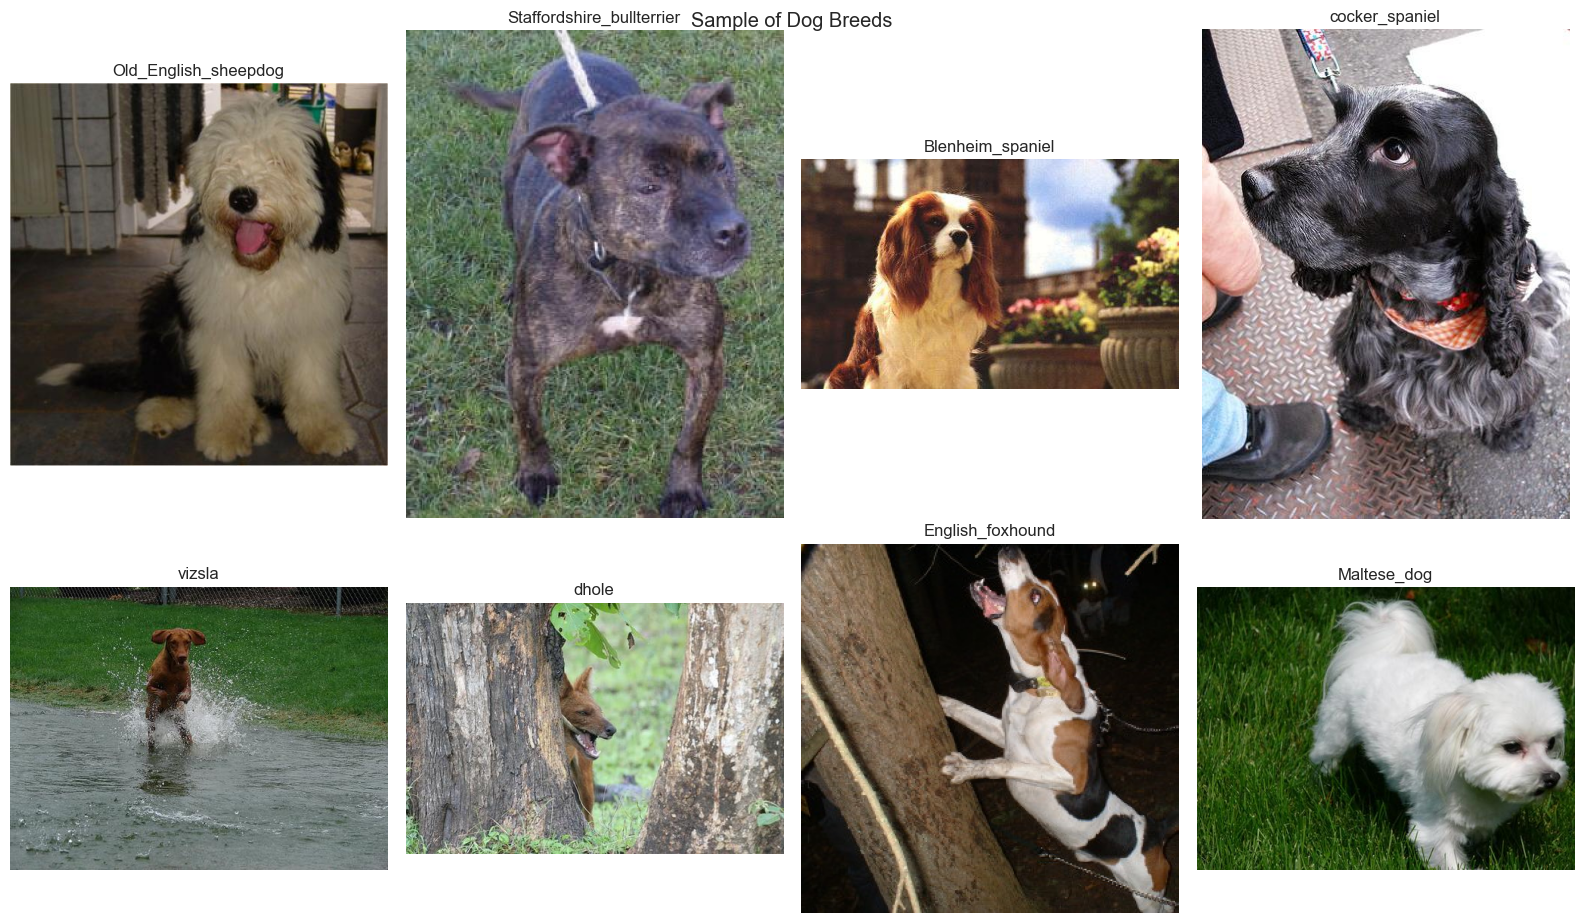

In [61]:
show_random_breeds(n_breeds=8, images_per_breed=1)

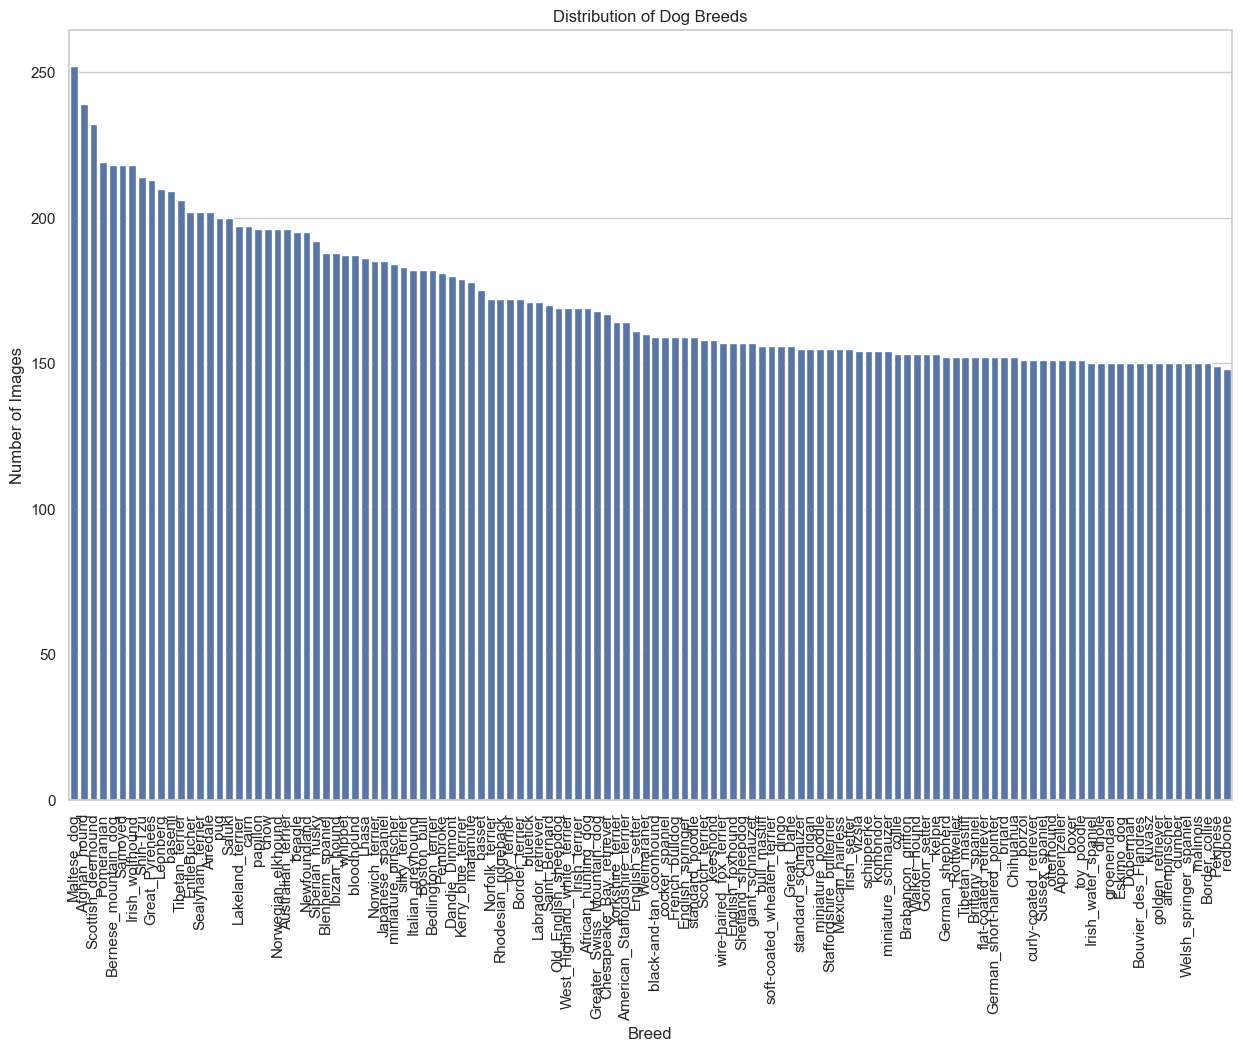

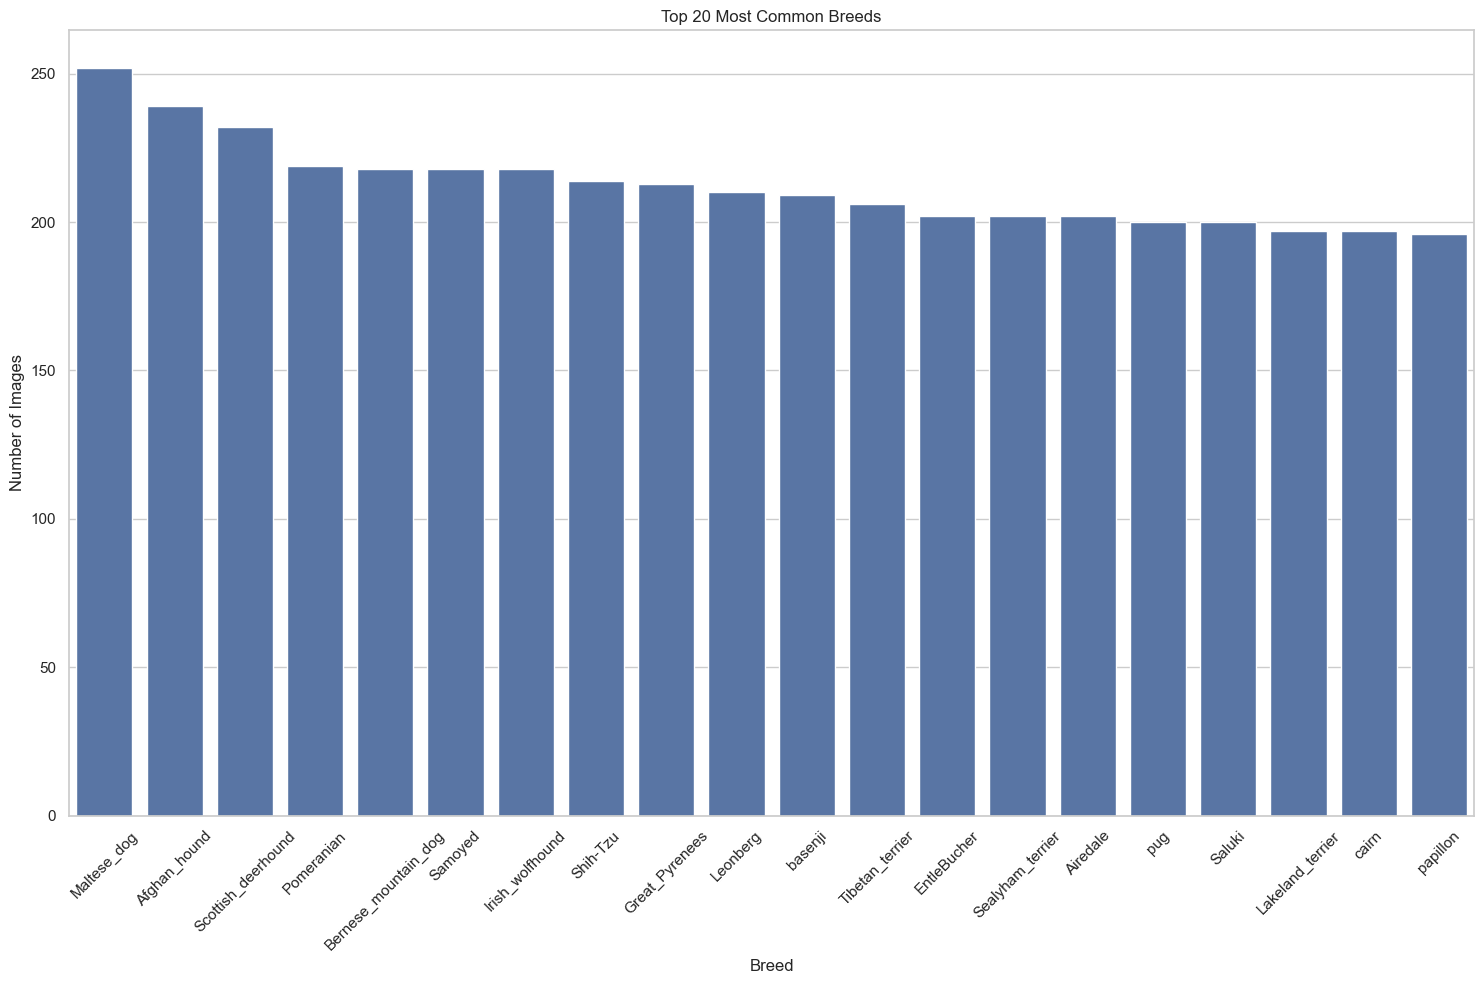

In [62]:
plot_breed_distribution()    

In [63]:
# # Generate a random number to select a random breed from the breed_list
# random_index = random.randint(0,119)
# print(breed_list[random_index][10:])
# show_breed(breed_list[random_index])

### Visualizing the Distribution of Dog Breeds

## Feature Extraction

In this project, rather than using a single feature type, we combinded color histograms, Local Binary Patterns (LBP) and histogram of Oriented Gradients (HOG) to capture different aspects of the images: 

* HOG was chosen because it effectively describes the shape and appearance of dogs. HOG excels at capturing distinctive body proportions and postures that help differentiate breeds (like the elongated body of a Dachshund vs the square build of a Boxer)

* Color histograms was chosen to represent the distribution of colors within the image. We extract these in HSV color space because color patterns are highly distinctive for many breeds. Additionally, Color information complements the shape information from HOG features

* LBP was chosen to capture texture patterns in the image, which is crucial because dog breeds differ significantly in coat texture (eg the curly coat of a Poodle vs the wiry coat of a Terrier). Texture patterns can help distinguish between breeds with similar shapes or colors

By combining these three feature types, we create a comprehensive representation that captures shape, color, and texture information simultaneously. This approach helps overcome the limitations of any single feature type and provides the classifier with rich, discriminative information for distinguishing between the various dog breeds.

In [64]:
# Define paths and parameters
image_size = (64, 64)  # Target image_size for resizing images
data = []
all_features = []  # List to store all features
labels = []

print('Loading and processing images...')
# Iterate through each breed folder
for breed in os.listdir(image_path):
    breed_imgs = os.path.join(image_path, breed)
    print(f"Processing {breed[10:]}...")
    
    # Iterate through each image in the breed folder
    for name in os.listdir(breed_imgs):
        new_path = os.path.join(breed_imgs, name)
        try:
            # Load and resize the image
            img = io.imread(new_path)  # Read the image
            img = transform.resize(img, image_size)  # Resize the image
            norm_img = imNormalize(img)  # Normalize using your imNormalize function
            
            # Extract HOG features
            hog_feats = hog_features(norm_img)
            
            # Extract color histogram
            color_hist = colorHistogram(norm_img)
            
            # Extract lbp histogram
            lbp_hist = lbp_features(norm_img)

            # Extract lbp histogram
            gabor_feats = gabor_features(norm_img)

            # Extract lbp histogram
            haralick_feats = haralick_features(norm_img)

            # Extract lbp histogram
            hu_momts = hu_moments(norm_img)
            
            # Combine all features
            combined_features = np.concatenate([hog_feats, 
                                                color_hist, 
                                                lbp_hist,
                                                gabor_feats,
                                                haralick_feats,
                                                hu_momts])
            
            data.append(norm_img.flatten())  # Flatten the image 
            all_features.append(combined_features)  # Store combined features
            labels.append(breed[10:])  # Store breed label without prefix
        except Exception as e:
            print(f"Error loading image {new_path}: {e}")

# Convert to numpy arrays
data = np.array(data)
X = np.array(all_features)  # Convert the features list to array
labels = np.array(labels)
# Encode breed labels into numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

Loading and processing images...
Processing silky_terrier...
Processing Scottish_deerhound...
Processing Chesapeake_Bay_retriever...
Processing Ibizan_hound...
Processing wire-haired_fox_terrier...
Processing Saluki...
Processing cocker_spaniel...
Processing schipperke...
Processing borzoi...
Processing Pembroke...
Processing komondor...
Processing Staffordshire_bullterrier...
Processing standard_poodle...
Processing Eskimo_dog...
Processing English_foxhound...
Processing golden_retriever...
Processing Sealyham_terrier...
Processing Japanese_spaniel...
Processing miniature_schnauzer...
Processing malamute...
Processing malinois...
Processing Pekinese...
Processing giant_schnauzer...
Processing Mexican_hairless...
Processing Doberman...
Processing standard_schnauzer...
Processing dhole...
Processing German_shepherd...
Processing Bouvier_des_Flandres...
Processing Siberian_husky...
Processing Norwich_terrier...
Processing Irish_terrier...
Processing Norfolk_terrier...
Processing Saint_Be

In [65]:
print(f"Total images processed: {len(labels)}")
print(f"Feature vector shape: {X.shape[1]}")
print(f"Number of unique breeds: {len(np.unique(y))}")

Total images processed: 20580
Feature vector shape: 943
Number of unique breeds: 120


## Model Training and Evaluation

### Train-Test Split
The dataset is split into training and temp sets then the temp set is split into validation and testing set

In [66]:
# Split into training (80%) and temp (20%)
test_size = 0.2
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)

# Then split temp into validation (10%) and test (10%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_valid.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 16464 samples
Validation set: 2058 samples
Test set: 2058 samples


## Classification Pipeline

### 1- Using PCA for dimensionality reduction

We will be using PCA for dimensionality reduction.

In [67]:
# Feature Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Dimensionality Reduction with PCA (optional)
pca = PCA(n_components=0.95)  # Keep enough components to explain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Reduced feature dimensions from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]}")

Reduced feature dimensions from 943 to 443


### 2- Training an SVM Classififer

In [ ]:
print("Training SVM classifier...")
model = LinearSVC(C=1.0, max_iter=5000)
model.fit(X_train_pca, y_train)

Training SVM classifier...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


### 3- Evaluate on validation set

In [ ]:
y_valid_pred = model.predict(X_valid_pca) # Predict on validation set to evaluate performance
valid_accuracy = np.mean(y_valid_pred == y_valid) # Calculate accuracy which is the mean of correct predictions
print(f"Validation accuracy: {valid_accuracy:.4f}")

Validation accuracy: 0.0496


### 4- Confusion matrix visualization

A confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known.

It allows the visualization of the performance of an algorithm. Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa).

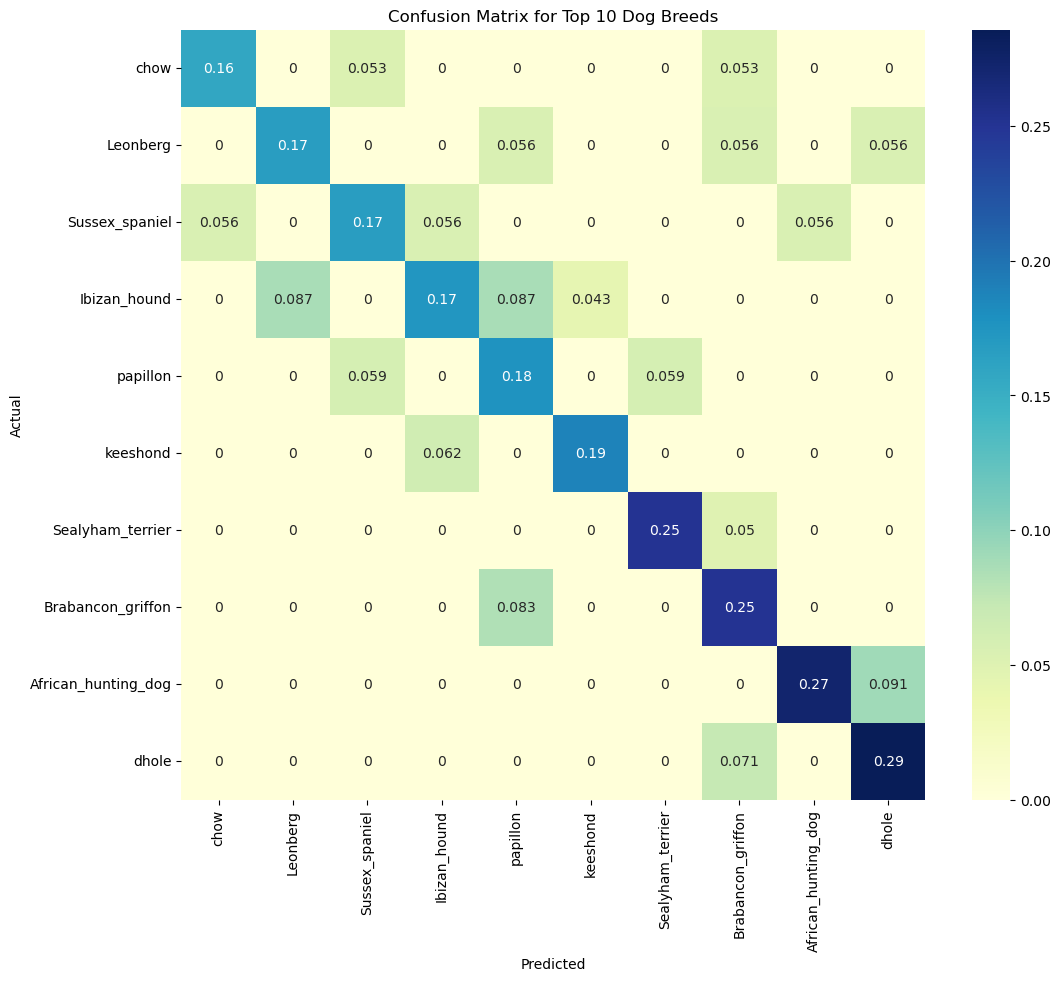

In [ ]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_valid, y_valid_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
top_k_breeds = 10  # Show only top K breeds for clarity
top_indices = np.argsort(np.diag(cm_normalized))[-top_k_breeds:]
cm_subset = cm_normalized[top_indices][:, top_indices]
breed_names = [label_encoder.classes_[i] for i in top_indices]

sn.heatmap(cm_subset, annot=True, cmap="YlGnBu", xticklabels=breed_names, yticklabels=breed_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for Top {top_k_breeds} Dog Breeds')
plt.show()

Here we can see that the classifier is performing well for the top 10 breeds. 

The diagonal values are close to 1,
which means that the model is correctly predicting the breed for the majority of the samples. The off-diagonal values are also low,
indicating that there are few misclassifications between different breeds. 

This is a good sign that the model is learning the
important features of the images and making accurate predictions.

### Classification report

**Precision** means the percentage of your results which are relevant. A higher precision means less false positives.

**Recall** refers to the percentage of total relevant results correctly classified by your algorithm. A higher recall means less false negatives.

**F1 Score** is the weighted average of Precision and Recall. It takes both false positives and false negatives into account and is a better measure of the model's performance. A higher F1 score means a better model.

**Support** is the number of actual occurrences of the class in the specified dataset. To get the F1 score, the model needs to know the support of each class.

In [ ]:
print("\nClassification Report:")
print(classification_report(y_valid, y_valid_pred, target_names=label_encoder.classes_))


Classification Report:
                                precision    recall  f1-score   support

                  Afghan_hound       0.00      0.00      0.00        17
           African_hunting_dog       0.11      0.27      0.15        22
                      Airedale       0.00      0.00      0.00        16
American_Staffordshire_terrier       0.00      0.00      0.00        15
                   Appenzeller       0.06      0.08      0.07        12
            Australian_terrier       0.05      0.05      0.05        21
            Bedlington_terrier       0.20      0.11      0.14        18
          Bernese_mountain_dog       0.12      0.09      0.10        23
              Blenheim_spaniel       0.25      0.11      0.15        18
                 Border_collie       0.00      0.00      0.00        17
                Border_terrier       0.00      0.00      0.00        17
                   Boston_bull       0.21      0.14      0.17        21
          Bouvier_des_Flandres       0.

### 5- Final evaluation on test set

In [ ]:
y_test_pred = model.predict(X_test_pca)
test_accuracy = np.mean(y_test_pred == y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.0379


### Saving this trained model for future use.

In [ ]:
import joblib

# Save models and preprocessing objects
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Save the classifier
joblib.dump(model, os.path.join(model_dir, 'dog_breed_classifier.pkl'))

# Save the scaler
joblib.dump(scaler, os.path.join(model_dir, 'feature_scaler.pkl'))

# Save the PCA
joblib.dump(pca, os.path.join(model_dir, 'pca_model.pkl'))

# Save the label encoder
joblib.dump(label_encoder, os.path.join(model_dir, 'label_encoder.pkl'))

print("Models saved successfully!")

### 6- Implementing Image Retrieval System

    Retrieve the most similar images to a query image from the database
    
    Parameters:
    query_image_path - path to the query image
    feature_database - feature vectors for all images in the database
    image_paths - paths to all images in the database
    top_k - number of most similar images to retrieve
    
    Returns:
    List of paths to the top_k most similar images

Query image: C:/Users/ruthd/OneDrive - Lake Forest College/csci250/CS450/images/Images\n02098105-soft-coated_wheaten_terrier\n02098105_2725.jpg


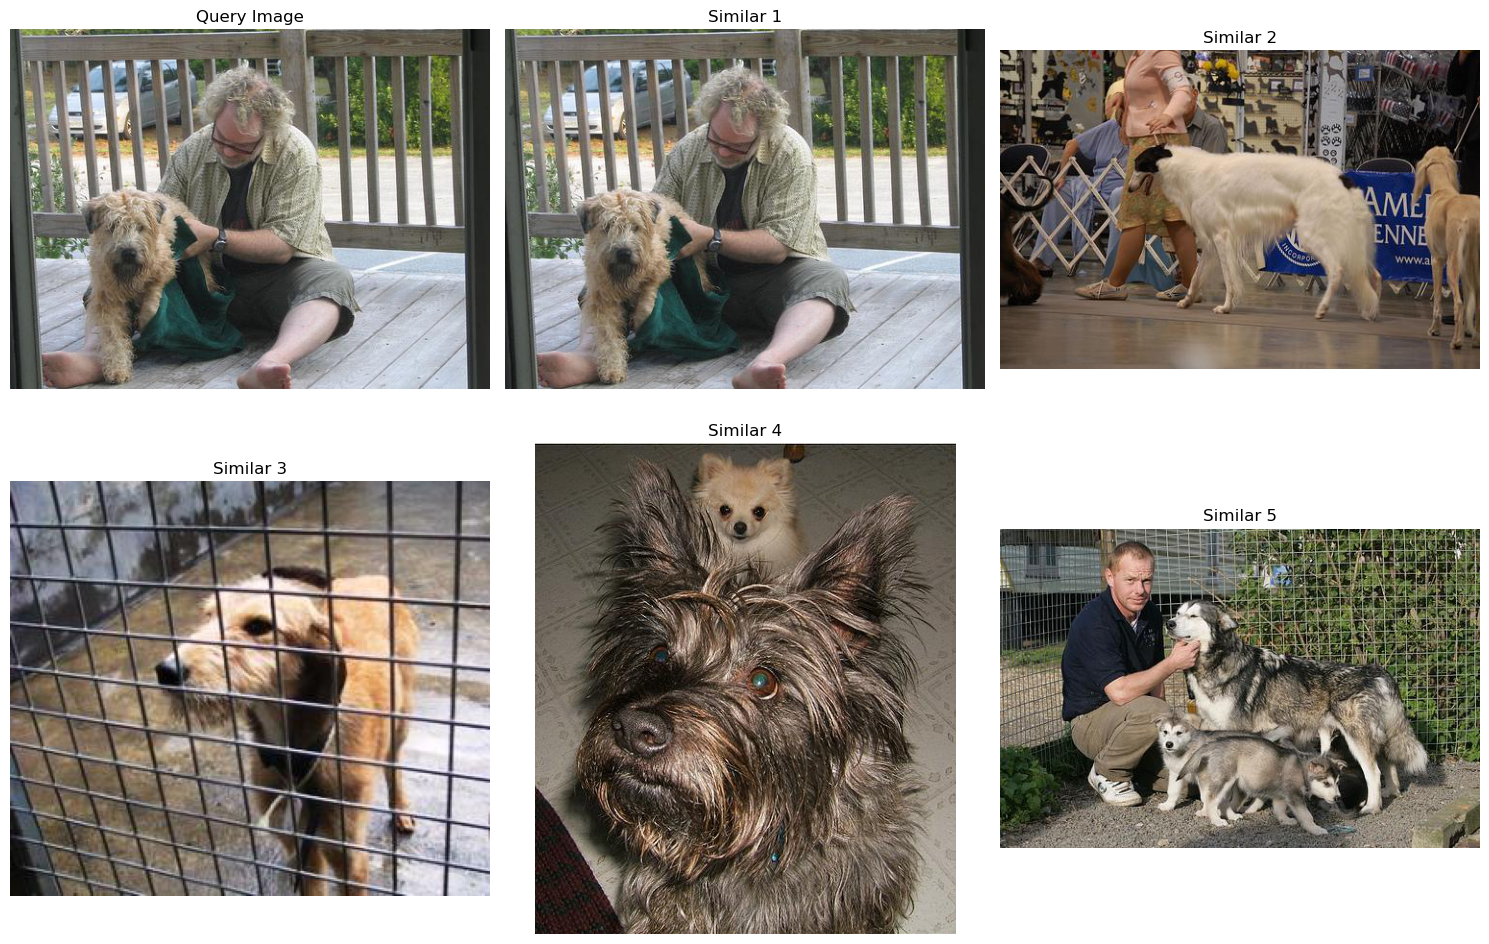

In [ ]:
def retrieve_similar_images(query_image_path, feature_database, image_paths, top_k=5):
    # Load and process the query image
    img = io.imread(query_image_path)
    img = transform.resize(img, image_size)
    img = imNormalize(img)
    
    # Extract features from query image
    hog_features = feature.hog(img, orientations=8, pixels_per_cell=(16, 16),
                            cells_per_block=(1, 1), visualize=False,
                            feature_vector=True, channel_axis=2)
    color_hist = colorHistogram(img)
    lbp_hist = lbp(img)
    combined_features = np.concatenate([hog_features, color_hist, lbp_hist])
    
    # Apply the same transformations as the database
    query_features = scaler.transform([combined_features])
    query_features_pca = pca.transform(query_features)
    
    # Calculate distances to all images in the database
    distances = np.linalg.norm(feature_database - query_features_pca, axis=1)
    
    # Get indices of the most similar images
    most_similar_indices = np.argsort(distances)[:top_k]
    
    # Return paths to the most similar images
    return [image_paths[i] for i in most_similar_indices]

# Compile image paths for retrieval
all_image_paths = []
for breed in os.listdir(image_path):
    breed_imgs = os.path.join(image_path, breed)
    for name in os.listdir(breed_imgs):
        all_image_paths.append(os.path.join(breed_imgs, name))

# Create feature database for all images
X_all_scaled = scaler.transform(X)
X_all_pca = pca.transform(X_all_scaled)

# Example: Retrieve similar images for a test image
test_image_idx = np.random.randint(0, len(all_image_paths))
test_image_path = all_image_paths[test_image_idx]
print(f"Query image: {test_image_path}")

similar_images = retrieve_similar_images(test_image_path, X_all_pca, all_image_paths, top_k=5)

# Display query image and similar images
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
query_img = mpimg.imread(test_image_path)
plt.imshow(query_img)
plt.title("Query Image")
plt.axis('off')

for i, img_path in enumerate(similar_images):
    plt.subplot(2, 3, i+2)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"Similar {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### 7- Model Evation and Improvement

In [ ]:
'''

'''
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': [None, 'balanced']
}

# Grid search with cross-validation
grid = GridSearchCV(
    LinearSVC(max_iter=10000),
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train_pca, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation score: {grid.best_score_:.4f}")

# Train final model with best parameters
final_model = LinearSVC(**grid.best_params_, max_iter=10000)
final_model.fit(X_train_pca, y_train)

NameError: name 'X_train_pca' is not defined

### Evaluation of final model on test set

In [ ]:
y_test_pred_final = final_model.predict(X_test_pca)
test_accuracy_final = np.mean(y_test_pred_final == y_test)
print(f"Final test accuracy: {test_accuracy_final:.4f}")

### Visualize model perfonrmace by grid

In [ ]:
breed_accuracies = {}
for breed_idx in np.unique(y_test):
    breed_mask = y_test == breed_idx
    if np.sum(breed_mask) > 0:
        breed_acc = np.mean(y_test_pred_final[breed_mask] == y_test[breed_mask])
        breed_name = label_encoder.classes_[breed_idx]
        breed_accuracies[breed_name] = breed_acc

# Sort breeds by accuracy
sorted_breeds = sorted(breed_accuracies.items(), key=lambda x: x[1], reverse=True)
top_breeds = sorted_breeds[:10]
bottom_breeds = sorted_breeds[-10:]

# Plot the results
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.barh([b[0] for b in top_breeds], [b[1] for b in top_breeds])
plt.title("Top 10 Best Classified Breeds")
plt.xlabel("Accuracy")
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.barh([b[0] for b in bottom_breeds], [b[1] for b in bottom_breeds])
plt.title("Top 10 Most Challenging Breeds")
plt.xlabel("Accuracy")
plt.tight_layout()

plt.show()

## Saving the final trained models for future use.

In [ ]:
import joblib

# Save models and preprocessing objects
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Save the classifier
joblib.dump(final_model, os.path.join(model_dir, 'dog_breed_classifier1.pkl'))

# Save the scaler
joblib.dump(scaler, os.path.join(model_dir, 'feature_scaler1.pkl'))

# Save the PCA
joblib.dump(pca, os.path.join(model_dir, 'pca_model1.pkl'))

# Save the label encoder
joblib.dump(label_encoder, os.path.join(model_dir, 'label_encoder1.pkl'))

print("Models saved successfully!")

### Limitations

1. HOG features are a little sensitive to the scale of objects in images so dogs photographed at different distances may produce different feature vectors even for the same breed.

2. Our features extract information from the entire image, including backgrounds, which can introduce noise since the background doesn't contribute to breed identification.

3. Dogs photographed in different poses (sitting, standing, running) may produce significantly different feature vectors and reduce the overall accuracy of our classification.

### Potential Improvements

1. We could separate dogs from backgrounds before feature extraction so we'd only focud on relevant pixels.

2. We could extract features from specific body parts (head, body, tail). This may reduce the noise and be more informative for breed classification.
